<a target="_blank" href="https://colab.research.google.com/github/sarthakrastogi/graph-rag/blob/main/examples/documents_graph_usage.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install knowledge_graph_rag
!pip install numpy==1.24.0
!pip install chromadb

'\n%%capture\n!pip install knowledge_graph_rag\n!pip install numpy==1.24.0\n!pip install chromadb\n'

In [2]:
%%capture
from knowledge_graph_rag.document import Document
from knowledge_graph_rag.documents_graph import DocumentsGraph

In [3]:

documents = ["Cardiovascular disease (CVD) encompasses a spectrum of disorders involving the heart and vasculature, prominently including atherosclerosis, characterized by endothelial dysfunction and the accumulation of lipid-laden plaques. These pathophysiological processes often precipitate myocardial infarction and cerebrovascular accidents, arising from the rupture of vulnerable plaques and subsequent thrombogenesis.",
             "Management of cardiovascular disease necessitates a multifaceted approach involving antihypertensive agents, statins to modulate dyslipidemia, and antiplatelet therapy to mitigate thrombosis risk.",
             "Emerging therapeutic interventions targeting molecular pathways, including PCSK9 inhibitors and SGLT2 inhibitors, show promise in reducing cardiovascular morbidity and mortality.",
             "The epidemiological burden of cardiovascular disease underscores the imperative for ongoing research into genetic predispositions and the optimization of primary and secondary prevention strategies."
             "Cardiovascular disease also significantly intersects with metabolic syndrome, wherein insulin resistance and visceral adiposity contribute to endothelial dysfunction and systemic inflammation, further accelerating atherogenic processes.",
             "Advanced imaging techniques, such as coronary artery calcium scoring and carotid intima-media thickness measurement, enhance the stratification of cardiovascular risk, enabling more tailored therapeutic interventions.",
             "Role of novel biomarkers, including high-sensitivity troponins and natriuretic peptides, is pivotal in the early detection and prognostication of acute coronary syndromes and heart failure within the broader spectrum of cardiovascular disease."
]

Graph RAG can perform much better than std RAG. Here’s when and how:

When you want your LLM to understand the interconnection between your documents before arriving to its answer, Graph RAG is necessary.

RAG returns search results based on semantic similarity. It fails to consider that, if doc A is selected as highly relevant, the docs containing data closely linked to doc A must be included in the context to give a full picture.

This is where we need Graph RAG.

Search results from a graph are more likely to give you a comprehensive view of the entity being searched and the info connected to it.

Information on entities like people, institutions, etc. is often highly interconnected, and this might be the case for your data too.


### 1. Create a VectorDB

In [4]:
def get_embedding_batch(input_array):
    from openai import OpenAI
    client = OpenAI(api_key="YOUR_OPENAI_API_KEY")
    response = client.embeddings.create(
        input=input_array,
        model="text-embedding-3-small"
    )
    return [data.embedding for data in response.data]

In [5]:
embeddings = get_embedding_batch(documents)
vectors_collection = [{document : embedding} for document, embedding in zip(documents, embeddings)]

In [6]:
import chromadb
vectordb_name = "cvd_vectors"
client = chromadb.PersistentClient(path=vectordb_name)
collection = client.create_collection(vectordb_name)

collection.add(
    embeddings=embeddings,
    documents=documents,
    metadatas=[{"source" : ""} for i in range(len(documents))],
    ids=list(map(str, range(len(documents))))
)

### 2. Create a Documents Graph

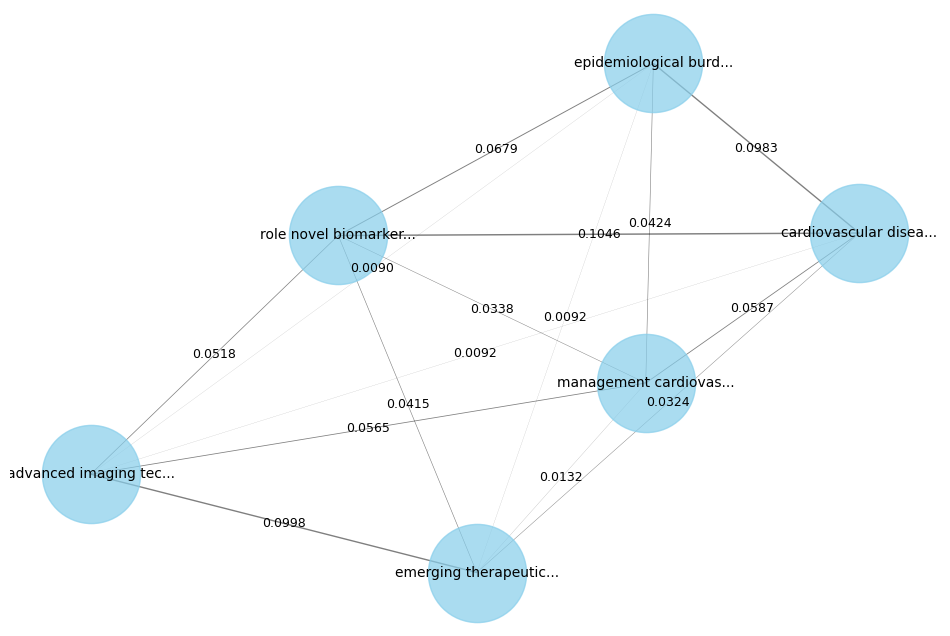

In [7]:
documents_graph = DocumentsGraph(documents=documents)
documents_graph.plot()

In [8]:
documents_graph.save("med_graph")

In [9]:
user_query = "How do advanced imaging techniques enhance cardiovascular risk stratification?"
query_embeddings = get_embedding_batch(user_query)

### 3. Search vectorDB

In [10]:
vectordb_search_result = collection.query(query_embeddings=query_embeddings, n_results=1)['documents'][0][0]
print(vectordb_search_result)

Advanced imaging techniques, such as coronary artery calcium scoring and carotid intima-media thickness measurement, enhance the stratification of cardiovascular risk, enabling more tailored therapeutic interventions.


### 4. Search Documents Graph

To find interconnected documents containing terminology / n-grams used in search result.

Search results from a graph can give you a comprehensive view of the entity being searched and the info connected to it.


In [11]:
documents_containing_connected_terminology = documents_graph.find_connected_documents(vectordb_search_result)
documents_containing_connected_terminology

[{'document': 'emerging therapeutic intervention targeting molecular pathway including inhibitor inhibitor show promise reducing cardiovascular morbidity mortality'},
 {'document': 'management cardiovascular disease necessitates multifaceted approach involving antihypertensive agent statin modulate dyslipidemia antiplatelet therapy mitigate thrombosis risk'},
 {'document': 'role novel biomarkers including troponins natriuretic peptide pivotal early detection prognostication acute coronary syndrome heart failure within broader spectrum cardiovascular disease'}]

### 5. Augment interconnected documents into context